In [4]:
!pip install nltk  # Install nltk if not already installed

In [5]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score



In [7]:
# Load the Twitter dataset

from google.colab import drive
drive.mount('/content/drive')


#data_path = '/Twitter_Data.csv'
data_path = '/content/drive/MyDrive/Colab Notebooks/Files/Twitter_Data.csv'
df = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:

# Display the first few rows of the dataset

print("Dataset preview:")
print(df.head())

# Check for missing values

print("\nMissing values:")
print(df.isnull().sum())

Dataset preview:
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

Missing values:
clean_text    4
category      7
dtype: int64


In [9]:

# Preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Removing special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Joining words back to form the preprocessed text
    return ' '.join(words)

In [10]:
# Apply preprocessing to the 'tweet' column (assuming the column name is 'tweet')

df['cleaned_tweet'] = df['clean_text'].astype(str).apply(preprocess_text)

In [11]:
# Display the first few rows of the processed data

print("\nProcessed data preview:")
print(df[['clean_text', 'cleaned_tweet', 'category']].head())


Processed data preview:
                                          clean_text  \
0  when modi promised “minimum government maximum...   
1  talk all the nonsense and continue all the dra...   
2  what did just say vote for modi  welcome bjp t...   
3  asking his supporters prefix chowkidar their n...   
4  answer who among these the most powerful world...   

                                       cleaned_tweet  category  
0  modi promised minimum government maximum gover...      -1.0  
1             talk nonsense continue drama vote modi       0.0  
2  say vote modi welcome bjp told rahul main camp...       1.0  
3  asking supporters prefix chowkidar names modi ...       1.0  
4  answer among powerful world leader today trump...       1.0  


In [12]:
# Save the preprocessed data to a new CSV for further analysis

output_path = '/mnt/Preprocessed_Twitter_Data.csv'
df.to_csv(output_path, index=False)
print(f"\nPreprocessed data saved to {output_path}")


Preprocessed data saved to /mnt/Preprocessed_Twitter_Data.csv



Sentiment label distribution:
category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64


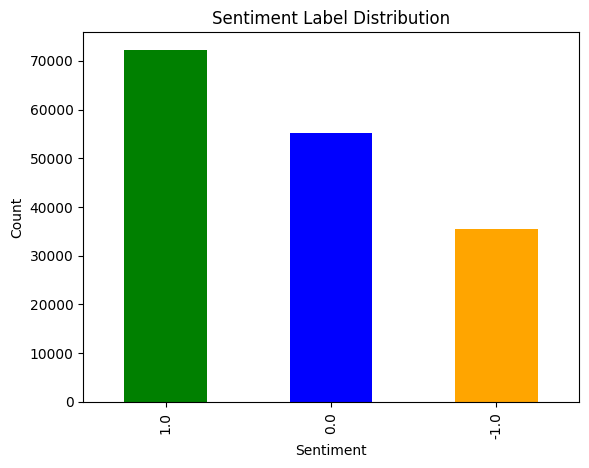

In [13]:
# Exploratory Data Analysis

# Distribution of sentiment labels
print("\nSentiment label distribution:")
print(df['category'].value_counts())
df['category'].value_counts().plot(kind='bar', title='Sentiment Label Distribution', color=['green', 'blue', 'orange'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


Most common words for -1.0 sentiment:
[('modi', 35260), ('india', 6358), ('people', 4070), ('bjp', 3621), ('congress', 3446), ('like', 3446), ('govt', 2634), ('poor', 2630), ('dont', 2342), ('one', 2269)]


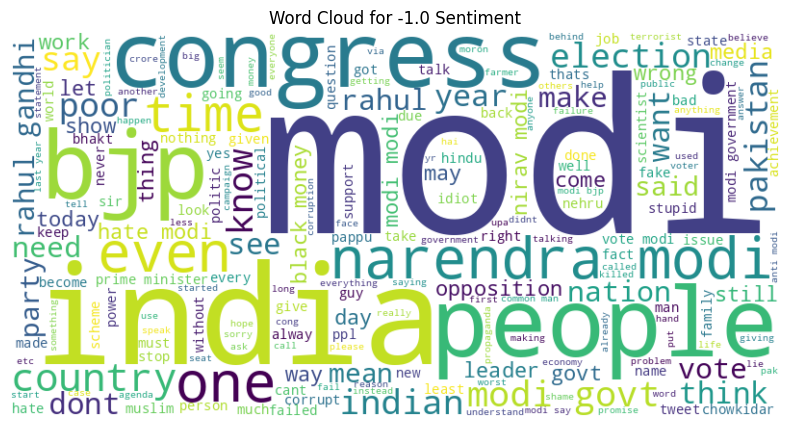


Most common words for 0.0 sentiment:
[('modi', 49852), ('india', 6735), ('narendra', 4017), ('bjp', 3981), ('congress', 3571), ('vote', 3055), ('like', 3053), ('people', 2872), ('modis', 2625), ('govt', 2496)]


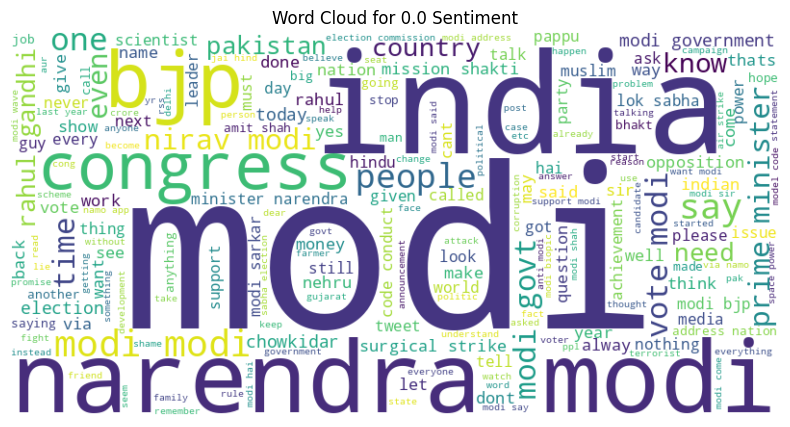


Most common words for 1.0 sentiment:
[('modi', 70520), ('india', 16087), ('bjp', 7062), ('people', 6956), ('like', 6086), ('congress', 5820), ('narendra', 5536), ('one', 4971), ('govt', 4905), ('good', 4793)]


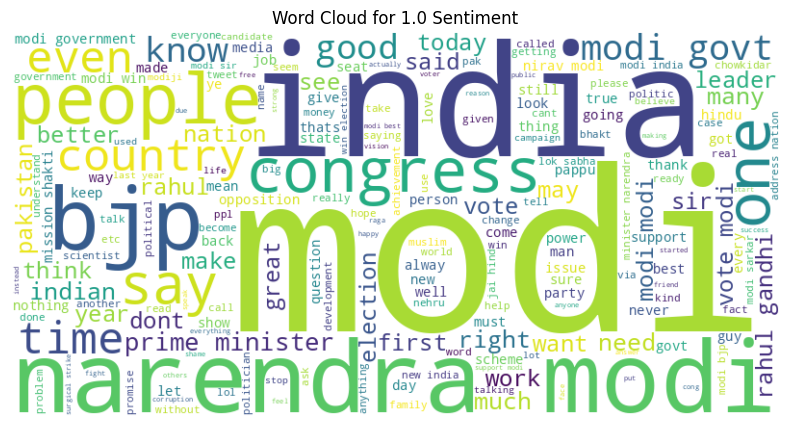


Invalid sentiment value: nan. Skipping.


In [14]:
# Most frequent words for each sentiment class
for sentiment in df['category'].unique():
    # Check if sentiment is valid and not NaN
    if pd.notna(sentiment):  # or if isinstance(sentiment, str):
        sentiment_words = ' '.join(df[df['category'] == sentiment]['cleaned_tweet'])
        # Check if sentiment_words is not empty
        if sentiment_words:
            word_counts = Counter(sentiment_words.split())
            print(f"\nMost common words for {sentiment} sentiment:")
            print(word_counts.most_common(10))

            # Generate and display a word cloud
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_words)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'Word Cloud for {sentiment} Sentiment')
            plt.axis('off')
            plt.show()
        else:
            print(f"\nNo words found for {sentiment} sentiment. Skipping word cloud generation.")
    else:
        print(f"\nInvalid sentiment value: {sentiment}. Skipping.")

In [15]:
# Sentiment distribution over time (if timestamp information is available)
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    sentiment_over_time = df.groupby([df['timestamp'].dt.date, 'sentiment']).size().unstack()
    sentiment_over_time.plot(kind='line', figsize=(10, 5), title='Sentiment Distribution Over Time')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.show()

In [16]:
# Feature Extraction using TF-IDF
print("\nExtracting features using TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['cleaned_tweet']).toarray()


Extracting features using TF-IDF...


In [17]:
# Labels (target variable)
print("\nPreparing labels...")
y = df['category']

# Drop rows with missing values in the target variable
df = df.dropna(subset=['category'])

# Re-extract features and labels after dropping rows
X = tfidf_vectorizer.fit_transform(df['cleaned_tweet']).toarray()
y = df['category']


Preparing labels...


In [18]:
# Splitting data into training and testing sets
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nData split complete:")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")


Splitting data into training and testing sets...

Data split complete:
Training set size: 130378 samples
Testing set size: 32595 samples


In [21]:
# Model Training using Naive Bayes
print("\nTraining Naive Bayes model...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


Training Naive Bayes model...


MultinomialNB()

In [22]:

# Model Evaluation
print("\nEvaluating model...")
y_pred = nb_model.predict(X_test)

# Display evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate and display accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



Evaluating model...

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.89      0.44      0.59      7230
         0.0       0.84      0.66      0.74     10961
         1.0       0.66      0.93      0.77     14404

    accuracy                           0.73     32595
   macro avg       0.79      0.68      0.70     32595
weighted avg       0.77      0.73      0.72     32595


Accuracy: 0.73
Precision: 0.77
Recall: 0.73
F1 Score: 0.72
